# Logistic Regression vs. FFN (binary and multiclass)
## on a synthetic dataset
### N.B. Generative AI was used to generate the datasets

In [57]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [58]:
data_binary = [
    ("good", 1),
    ("bad", 0),
    ("awesome", 1),
    ("terrible", 0),
    ("great", 1),
    ("horrible", 0),
    ("excellent", 1),
    ("poor", 0),
    ("not good", 0),
    ("not bad", 1),
    ("not terrible", 1),
    ("not great", 0),
    ("not horrible", 1),
    ("not awesome", 0),
    ("not poor", 1),
    ("very good", 1),
    ("very bad", 0),
    ("very great", 1),
    ("very horrible", 0),
    ("not very good", 0),
    ("not very bad", 1),
    ("not very great", 0),
    ("not very horrible", 1),
    ("not very awesome", 0),
    ("not very poor", 1),
    ("good good", 1),
    ("bad bad", 0),
    ("not not bad", 0),
    ("not not good", 1),
    ("not not terrible", 0),
    ("not not awesome", 1),
    ("very very good", 1),
    ("very very bad", 0),
    ("good and bad", 0),
    ("bad and good", 0),
    ("awesome but terrible", 1),
    ("terrible but awesome", 1),
    ("good but not great", 0),
    ("great but not good", 1),
    ("not good but not bad", 1),
    ("not bad but not good", 0),
    ("excellent", 1),
    ("awful", 0),
    ("not awful", 1),
    ("not excellent", 0),
    ("very awful", 0),
    ("very excellent", 1),
    ("not very awful", 1),
    ("not very excellent", 0),
]

data_multiclass = [
    ("good", 2),
    ("bad", 0),
    ("awesome", 2),
    ("terrible", 0),
    ("great", 2),
    ("horrible", 0),
    ("excellent", 2),
    ("poor", 0),
    ("okay", 1),
    ("fine", 1),
    ("average", 1),
    ("not good", 0),
    ("not bad", 1),
    ("not terrible", 1),
    ("not great", 1),
    ("not horrible", 1),
    ("not awesome", 1),
    ("not poor", 1),
    ("very good", 2),
    ("very bad", 0),
    ("very great", 2),
    ("very horrible", 0),
    ("not very good", 1),
    ("not very bad", 1),
    ("not very great", 1),
    ("not very horrible", 1),
    ("not very awesome", 1),
    ("not very poor", 1),
    ("good good", 2),
    ("bad bad", 0),
    ("not not bad", 1),
    ("not not good", 2),
    ("not not terrible", 1),
    ("not not awesome", 2),
    ("very very good", 2),
    ("very very bad", 0),
    ("good and bad", 1),
    ("bad and good", 1),
    ("awesome but terrible", 1),
    ("terrible but awesome", 1),
    ("good but not great", 1),
    ("great but not good", 2),
    ("not good but not bad", 1),
    ("not bad but not good", 1),
    ("excellent", 2),
    ("awful", 0),
    ("not awful", 1),
    ("not excellent", 1),
    ("very awful", 0),
    ("very excellent", 2),
    ("not very awful", 1),
    ("not very excellent", 1),
]


In [59]:
# raw data
X_bin, Y_bin = [p[0] for p in data_binary], np.array([[p[1]] for p in data_binary])
X_multi, Y_multi = [p[0] for p in data_multiclass], np.array([[p[1]] for p in data_multiclass])

# tfidf features = character n-grams
tfidf = TfidfVectorizer(ngram_range=(1,4), analyzer='char')
X_bin_transformed = tfidf.fit_transform(X_bin)
X_multi_transformed = tfidf.fit_transform(X_multi)


print(f'binary examples, features: {X_bin_transformed.shape}')
print(f'multiclass examples, features: {X_multi_transformed.shape}')

binary examples, features: (49, 255)
multiclass examples, features: (52, 280)


### Logistic Regression

#### Binary

In [60]:
lr = LogisticRegression(C=1, max_iter=20)
lr.fit(X_bin_transformed, Y_bin.ravel())
y_hat = lr.predict(X_bin_transformed)

print(f'f1-score on the set: {f1_score(Y_bin, y_hat)}')

f1-score on the set: 0.7272727272727273


#### Multiclass

f1-score on the set: 0.8653846153846154


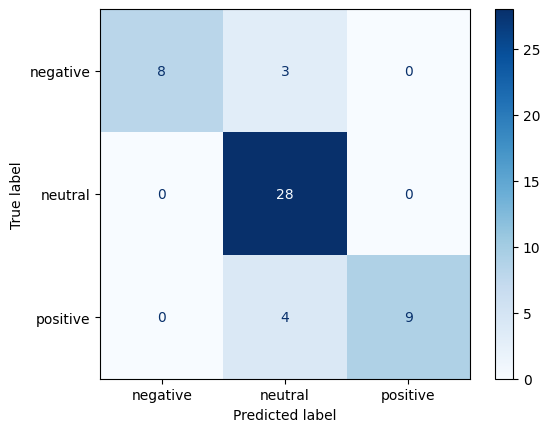

In [61]:
lr = LogisticRegression(C=1, max_iter=20)
lr.fit(X_multi_transformed, Y_multi.ravel())
y_hat_multi = lr.predict(X_multi_transformed)

print(f'f1-score on the set: {f1_score(Y_multi, y_hat_multi, average="micro")}')

ConfusionMatrixDisplay(confusion_matrix(y_pred=y_hat_multi, y_true=Y_multi.ravel()), display_labels=['negative', 'neutral', 'positive']).plot(cmap=plt.cm.Blues)
plt.show()

### FFN

In [62]:
class FFN(nn.Module):
   def __init__(self, in_feats, hidden_size, out_classes):
       super(FFN, self).__init__()
       self.clf1 = nn.Linear(in_feats, hidden_size)
       self.relu = nn.ReLU()
       self.clf2 = nn.Linear(hidden_size, out_classes)
   def forward(self, X):
       return self.clf2(self.relu(self.clf1(X)))

#### Binary

In [64]:
ffn = FFN(in_feats=X_bin_transformed.shape[1],hidden_size=32, out_classes=1)
opt = torch.optim.AdamW(ffn.parameters(), lr=0.05)
loss_fn = nn.BCEWithLogitsLoss()

X_bin_tensor = torch.tensor(X_bin_transformed.toarray(), dtype=torch.float32)
Y_bin_tensor = torch.tensor(Y_bin, dtype=torch.float32)

for epoch in range(20):
   opt.zero_grad()

   y_hat = ffn.forward(X_bin_tensor)
   loss = loss_fn(y_hat, Y_bin_tensor)
   loss.backward()
   opt.step()

   with torch.no_grad():
      y_hat_eval = [1 if torch.sigmoid(_) >= 0.5 else 0 for _ in y_hat]
      print(f'f1-score on the set: {f1_score(Y_bin_tensor, y_hat_eval)}')


f1-score on the set: 0.6756756756756757
f1-score on the set: 0.7037037037037037
f1-score on the set: 0.7272727272727273
f1-score on the set: 0.7636363636363637
f1-score on the set: 0.7307692307692307
f1-score on the set: 0.7659574468085106
f1-score on the set: 0.88
f1-score on the set: 0.8846153846153846
f1-score on the set: 0.92
f1-score on the set: 0.92
f1-score on the set: 0.92
f1-score on the set: 0.96
f1-score on the set: 0.96
f1-score on the set: 0.96
f1-score on the set: 0.96
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0


#### Multiclass

f1-score on the set: 0.5384615384615384
f1-score on the set: 0.5384615384615384
f1-score on the set: 0.5384615384615384
f1-score on the set: 0.7307692307692307
f1-score on the set: 0.8846153846153846
f1-score on the set: 0.8846153846153846
f1-score on the set: 0.9615384615384616
f1-score on the set: 0.9423076923076923
f1-score on the set: 0.9615384615384616
f1-score on the set: 0.9807692307692307
f1-score on the set: 0.9807692307692307
f1-score on the set: 0.9807692307692307
f1-score on the set: 1.0
f1-score on the set: 0.9807692307692307
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0


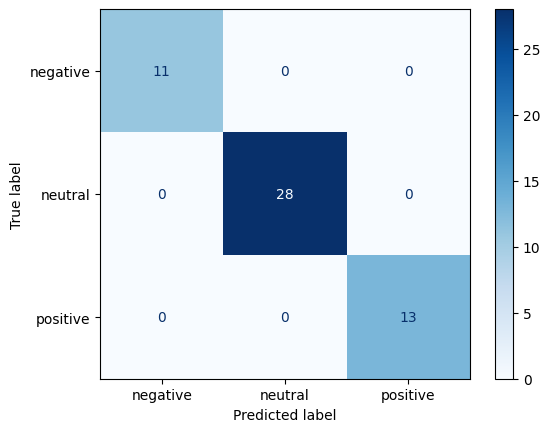

In [65]:
ffn = FFN(in_feats=X_multi_transformed.shape[1],hidden_size=32, out_classes=3)
opt = torch.optim.AdamW(ffn.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

X_multi_tensor = torch.tensor(X_multi_transformed.toarray(), dtype=torch.float32)
Y_multi_tensor = torch.tensor(Y_multi, dtype=torch.long)

y_hat_multi_ffn = None
for epoch in range(20):
   opt.zero_grad()

   y_hat = ffn.forward(X_multi_tensor)
   loss = loss_fn(y_hat, Y_multi_tensor.squeeze(dim=1))
   loss.backward()
   opt.step()

   with torch.no_grad():
      y_hat_eval = torch.argmax(y_hat, dim=1)
      y_hat_multi_ffn = y_hat_eval
      print(f'f1-score on the set: {f1_score(Y_multi_tensor, y_hat_eval, average="micro")}')

ConfusionMatrixDisplay(confusion_matrix(y_pred=y_hat_multi_ffn, y_true=Y_multi.ravel()), display_labels=['negative', 'neutral', 'positive']).plot(cmap=plt.cm.Blues)
plt.show()

f1-score on the set: 0.6538461538461539
f1-score on the set: 0.8461538461538461
f1-score on the set: 0.9615384615384616
f1-score on the set: 0.9615384615384616
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 0.9807692307692307
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0


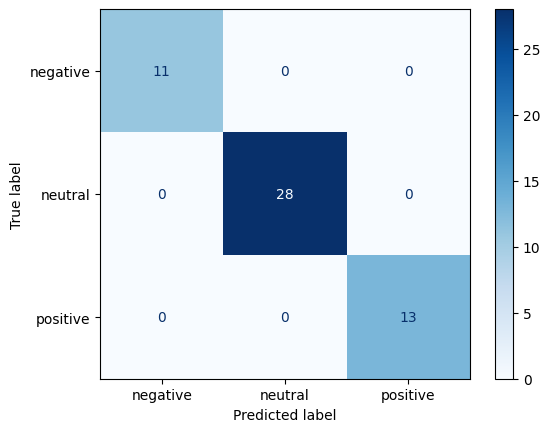

In [67]:
class GRU(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
     super(GRU, self).__init__()
     self.hidden_size = hidden_size
     self.gru = nn.GRU(input_size, hidden_size)
     self.clf1 = nn.Linear(hidden_size, output_size)

  def forward(self, X):
      h0 = torch.zeros(1, self.hidden_size)
      _, h0 = self.gru(X.unsqueeze(dim=0), h0)
      return self.clf1(h0)

labels = set()
for _, label in data_multiclass:
    labels.add(label)

X_multi_tensor = torch.tensor(X_multi_transformed.toarray(), dtype=torch.float32)
Y_multi_tensor = torch.tensor(Y_multi, dtype=torch.long)

gru = GRU(input_size=X_multi_tensor.shape[1], hidden_size=32, output_size=len(labels))
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(gru.parameters(), lr=0.05)


for epoch in range(20):
   for i in range(len(X_multi_tensor)):
      x_tensor, y_tensor = X_multi_tensor[i], Y_multi_tensor[i]

      opt.zero_grad()
      pred_tensor = gru.forward(x_tensor)
      loss = loss_fn(pred_tensor, y_tensor)
      loss.backward()
      opt.step()
   with torch.no_grad():
      Y_pred = []
      for i in range(len(X_multi_tensor)):
          x_tensor = X_multi_tensor[i]
          pred_tensor = gru.forward(x_tensor)
          Y_pred.append(torch.argmax(pred_tensor, dim=1).item())
      print(f'f1-score on the set: {f1_score(Y_multi, Y_pred, average="micro")}')

ConfusionMatrixDisplay(confusion_matrix(y_pred=Y_pred, y_true=Y_multi.ravel()), display_labels=['negative', 'neutral', 'positive']).plot(cmap=plt.cm.Blues)
plt.show()